In [3]:
# Cell 1: install dependencies
!pip install scikit-image imutils scikit-learn


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 960.0 kB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.8 MB 3.3 MB/s eta 0:00:04
    --------------------------------------- 0.3/12.8 MB 3.5 MB/s eta 0:00:04
   - -------------------------------------- 0.5/12.8 MB 3.9 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/12.8 MB 4.3 MB/s eta 0:


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install opencv-python


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/39.0 MB 4.8 MB/s eta 0:00:09
   -- ------------------------------------- 2.4/39.0 MB 30.7 MB/s eta 0:00:02
   ------- -------------------------------- 7.6/39.0 MB 69.4 MB/s eta 0:00:01
   ------------- -------------------------- 13.0/39.0 MB 131.2 MB/s eta 0:00:01
   ------------------ --------------------- 18.4/39.0 MB 129.5 MB/s eta 0:00:01
   ------------------------ --------------- 23.8/39.0 MB 131.2 MB/s eta 0:00:01
   ----------------------------- ---------- 29.1/39.0 MB 131.2 MB/s eta 0:00:01
   ----------------------------------- ---- 34.3/39.0 MB 131.2 MB/s eta 0:00:01
   ---------------------------------------  39.0/39.0 MB 108.8 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 81.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
# Cell 2: imports & paths
import os, random
import numpy as np
import pandas as pd
from skimage import io
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils.object_detection import non_max_suppression

# ← Update these to match your machine:
BASE_DIR = r"C:\Users\Ali A\Desktop\School\APS360\Project\APS360-Dental-Divot-Detection-1\datasets\smile\combined\meta"
CSV_PATH = os.path.join(BASE_DIR, "bounding_boxes.csv")
IMAGE_DIR = os.path.join(BASE_DIR, "images_with_bboxes")

# load your annotations
ann_df = pd.read_csv(CSV_PATH)  
# must have columns: image_filename, x_min, y_min, x_max, y_max (all normalized between 0 and 1)


In [16]:
def extract_patches(image_dir, ann_df,
                    patch_size=(64,64),
                    neg_ratio=1.0,
                    max_neg_trials=50):
    pos, neg = [], []

    # detect whether CSV values look normalized (<1) or absolute (>1)
    abs_vals = ann_df[['x_min','y_min','x_max','y_max']].max().max() > 1

    for fname, group in ann_df.groupby('image_filename'):
        img_path = os.path.join(image_dir, fname)
        if not os.path.isfile(img_path):
            continue
        img = io.imread(img_path, as_gray=True)
        H, W = img.shape

        bboxes = []
        for _, r in group.iterrows():
            # skip NaNs
            if pd.isnull(r.x_min) or pd.isnull(r.y_min) \
            or pd.isnull(r.x_max) or pd.isnull(r.y_max):
                continue

            if abs_vals:
                # already pixels
                x1, y1 = int(r.x_min), int(r.y_min)
                x2, y2 = int(r.x_max), int(r.y_max)
            else:
                # normalized in [0,1]
                x1 = int(r.x_min * W)
                y1 = int(r.y_min * H)
                x2 = int(r.x_max * W)
                y2 = int(r.y_max * H)

            # sanity checks
            if x2 <= x1 or y2 <= y1:
                continue
            # clip to image bounds
            x1, y1 = max(0,x1), max(0,y1)
            x2, y2 = min(W,x2), min(H,y2)

            bboxes.append((x1, y1, x2, y2))

        # positive patches
        for x1, y1, x2, y2 in bboxes:
            patch = img[y1:y2, x1:x2]
            if patch.size == 0:
                continue
            pos.append(resize(patch, patch_size))

        # negative patches
        for _ in range(int(len(bboxes) * neg_ratio)):
            for _ in range(max_neg_trials):
                x = random.randint(0, W - patch_size[1])
                y = random.randint(0, H - patch_size[0])
                rect = (x, y, x + patch_size[1], y + patch_size[0])

                # simple IoU  
                def iou(a, b):
                    xa, ya = max(a[0], b[0]), max(a[1], b[1])
                    xb, yb = min(a[2], b[2]), min(a[3], b[3])
                    inter = max(0, xb - xa) * max(0, yb - ya)
                    A = (a[2] - a[0]) * (a[3] - a[1])
                    B = (b[2] - b[0]) * (b[3] - b[1])
                    return inter / (A + B - inter) if inter > 0 else 0

                if all(iou(rect, bb) < 0.1 for bb in bboxes):
                    neg_patch = img[y:y + patch_size[0], x:x + patch_size[1]]
                    if neg_patch.size == 0:
                        continue
                    neg.append(resize(neg_patch, patch_size))
                    break

    return pos, neg

pos_patches, neg_patches = extract_patches(IMAGE_DIR, ann_df)
print(f"Got {len(pos_patches)} positive patches and {len(neg_patches)} negative patches.")


Got 5355 positive patches and 5355 negative patches.


In [17]:
import pandas as pd

print("Total rows:", len(ann_df))
print("Rows with any NaN in bbox coords:", 
      ann_df[['x_min','y_min','x_max','y_max']].isnull().any(axis=1).sum())

print("Unique filenames:", ann_df['image_filename'].nunique())
print("Sample filenames:", ann_df['image_filename'].unique()[:10])


Total rows: 5355
Rows with any NaN in bbox coords: 0
Unique filenames: 973
Sample filenames: ['dc1000_195.png' 'dc1000_181.png'
 'dental_radiography_0078_jpg.rf.3df5e76aaf3853ffeb55283ed9666c1e.jpg'
 'dc1000_630.png' 'dc1000_156.png' 'dc1000_142.png' 'dc1000_624.png'
 'dental_radiography_0054_jpg.rf.b81c1de4282e2881bc92f9d5b6ca106f.jpg'
 'opg_xray_5.jpg' 'dc1000_618.png']


In [18]:
# Cell 4: HOG feature extraction & dataset prep
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split

def compute_hog_features(patches):
    return np.array([
        hog(p,
            orientations=9,
            pixels_per_cell=(8,8),
            cells_per_block=(2,2),
            block_norm='L2-Hys')
        for p in patches
    ])

X_pos = compute_hog_features(pos_patches)
X_neg = compute_hog_features(neg_patches)
y_pos = np.ones(len(X_pos))
y_neg = np.zeros(len(X_neg))

# combine and split
X = np.vstack([X_pos, X_neg])
y = np.concatenate([y_pos, y_neg])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train set:", X_train.shape, y_train.sum(), "positives")
print("Test set: ", X_test.shape, y_test.sum(), "positives")


Train set: (8568, 1764) 4284.0 positives
Test set:  (2142, 1764) 1071.0 positives


In [19]:
# Cell 5: train & evaluate the linear SVM classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

clf = make_pipeline(
    StandardScaler(),
    LinearSVC(max_iter=5000, random_state=42)
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1071
         1.0       0.99      1.00      0.99      1071

    accuracy                           0.99      2142
   macro avg       0.99      0.99      0.99      2142
weighted avg       0.99      0.99      0.99      2142



In [20]:
# Cell 6: sliding-window detector + NMS demo on a real image
from imutils.object_detection import non_max_suppression
from skimage.transform import resize

def sliding_window(img, step, ws):
    for y in range(0, img.shape[0] - ws[1] + 1, step):
        for x in range(0, img.shape[1] - ws[0] + 1, step):
            yield x, y, img[y:y+ws[1], x:x+ws[0]]

def detect(img, clf, ws=(64,64), step=16, thresh=0.5):
    rects, scores = [], []
    for x, y, win in sliding_window(img, step, ws):
        feat = hog(resize(win, ws),
                   orientations=9,
                   pixels_per_cell=(8,8),
                   cells_per_block=(2,2),
                   block_norm='L2-Hys')
        score = clf.decision_function([feat])[0]
        if score > thresh:
            rects.append((x, y, x+ws[0], y+ws[1]))
            scores.append(score)
    picks = non_max_suppression(np.array(rects), scores, overlapThresh=0.3)
    return picks

# choose a sample image from your annotations
test_fname = ann_df['image_filename'].iloc[0]
test_path  = os.path.join(IMAGE_DIR, test_fname)
test_img   = io.imread(test_path, as_gray=True)

boxes = detect(test_img, clf)
print(f"Detections for {test_fname}: {boxes}")


Detections for dc1000_195.png: [[  80   16  144   80]
 [ 928    0  992   64]
 [ 160   16  224   80]
 [ 240    0  304   64]
 [2816   16 2880   80]
 [   0    0   64   64]
 [ 736  560  800  624]
 [1472  112 1536  176]
 [2768   16 2832   80]]


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# 5b) overall accuracy & error rate
acc = accuracy_score(y_test, y_pred)
err = 1 - acc
print(f"Overall accuracy: {acc:.4f}")
print(f"Error rate:       {err:.4f}")

# 5c) confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (rows=true, cols=predicted):")
print(cm)

# Optionally, cross-validation to estimate variance
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"5-fold CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Overall accuracy: 0.9930
Error rate:       0.0070
Confusion matrix (rows=true, cols=predicted):
[[1057   14]
 [   1 1070]]
5-fold CV accuracy: 0.9700 ± 0.0551


In [ ]:
# CNN on split2: fresh, self-contained pipeline
%pip install torch torchvision matplotlib -q
import warnings; warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Paths for split2
import os, glob
from skimage import io

ROOT = os.getcwd()
SMILE_DIR = os.path.join(ROOT, 'datasets', 'smile')
SPLIT2_DIR = os.path.join(SMILE_DIR, 'split2')
TRAIN_DIR = os.path.join(SPLIT2_DIR, 'train')
VAL_DIR   = os.path.join(SPLIT2_DIR, 'val')
TEST_DIR  = os.path.join(SPLIT2_DIR, 'test')

print('Using split2:', SPLIT2_DIR)
print('Counts:',
      len(glob.glob(os.path.join(TRAIN_DIR, 'images', '*.*'))),
      len(glob.glob(os.path.join(VAL_DIR,   'images', '*.*'))),
      len(glob.glob(os.path.join(TEST_DIR,  'images', '*.*'))))


Using split2: c:\Users\Ali A\Desktop\School\APS360\Project\APS360-Dental-Divot-Detection-1\datasets\smile\split2
Counts: 4176 522 523


In [4]:
# YOLO utils and patch extraction for split2
import numpy as np
from skimage.transform import resize

# Read YOLO labels
# Format per line: class xc yc w h (all normalized)
# Use class 0 as cavity

def read_yolo(label_path):
    boxes = []
    if not os.path.isfile(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = parts
            if int(float(cls)) != 0:
                continue
            boxes.append((float(xc), float(yc), float(w), float(h)))
    return boxes


def yolo_to_xyxy(box, W, H):
    xc, yc, w, h = box
    x1 = int((xc - w/2) * W)
    y1 = int((yc - h/2) * H)
    x2 = int((xc + w/2) * W)
    y2 = int((yc + h/2) * H)
    x1, y1 = max(0,x1), max(0,y1)
    x2, y2 = min(W,x2), min(H,y2)
    if x2 <= x1 or y2 <= y1:
        return None
    return (x1, y1, x2, y2)


def extract_patches_split(split_dir, patch_size=(64,64), neg_ratio=1.0, max_neg_trials=50):
    img_dir = os.path.join(split_dir, 'images')
    lbl_dir = os.path.join(split_dir, 'labels')
    image_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))

    pos, neg = [], []
    for img_path in image_files:
        fname = os.path.basename(img_path)
        label_path = os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt')
        img = io.imread(img_path, as_gray=True)
        H, W = img.shape

        yolo_boxes = read_yolo(label_path)
        bboxes = []
        for b in yolo_boxes:
            px = yolo_to_xyxy(b, W, H)
            if px is not None:
                bboxes.append(px)

        # positive patches
        for (x1,y1,x2,y2) in bboxes:
            patch = img[y1:y2, x1:x2]
            if patch.size == 0:
                continue
            pos.append(resize(patch, patch_size))

        # negative patches sampled away from GT boxes
        num_neg = max(1, int(len(bboxes) * neg_ratio))
        for _ in range(num_neg):
            for _ in range(max_neg_trials):
                x = np.random.randint(0, max(1, W - patch_size[1]))
                y = np.random.randint(0, max(1, H - patch_size[0]))
                rect = (x, y, x + patch_size[1], y + patch_size[0])

                def iou(a, b):
                    xa, ya = max(a[0], b[0]), max(a[1], b[1])
                    xb, yb = min(a[2], b[2]), min(a[3], b[3])
                    inter = max(0, xb - xa) * max(0, yb - ya)
                    A = (a[2] - a[0]) * (a[3] - a[1])
                    B = (b[2] - b[0]) * (b[3] - b[1])
                    return inter / (A + B - inter + 1e-7)

                if all(iou(rect, bb) < 0.1 for bb in bboxes):
                    neg_patch = img[y:y + patch_size[0], x:x + patch_size[1]]
                    if neg_patch.size == 0:
                        continue
                    neg.append(resize(neg_patch, patch_size))
                    break
    return pos, neg

pos_tr, neg_tr = extract_patches_split(TRAIN_DIR, patch_size=(64,64), neg_ratio=1.0)
pos_vl, neg_vl = extract_patches_split(VAL_DIR, patch_size=(64,64), neg_ratio=1.0)
pos_ts, neg_ts = extract_patches_split(TEST_DIR, patch_size=(64,64), neg_ratio=1.0)

print('Split2 patches — Train pos/neg:', len(pos_tr), len(neg_tr))
print('Split2 patches — Val   pos/neg:', len(pos_vl), len(neg_vl))
print('Split2 patches — Test  pos/neg:', len(pos_ts), len(neg_ts))


Split2 patches — Train pos/neg: 45399 45399
Split2 patches — Val   pos/neg: 6001 6001
Split2 patches — Test  pos/neg: 6053 6053


In [5]:
# Build datasets/loaders and define CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report

# Assemble arrays
import numpy as np

def stack_xy(pos_list, neg_list):
    X = np.concatenate([np.stack(pos_list, axis=0), np.stack(neg_list, axis=0)], axis=0).astype(np.float32)
    y = np.concatenate([
        np.ones(len(pos_list), dtype=np.float32),
        np.zeros(len(neg_list), dtype=np.float32)
    ], axis=0)
    return X, y

X_tr, y_tr = stack_xy(pos_tr, neg_tr)
X_vl, y_vl = stack_xy(pos_vl, neg_vl)
X_ts, y_ts = stack_xy(pos_ts, neg_ts)

# normalize using train stats
mean_s2 = X_tr.mean(); std_s2 = X_tr.std() + 1e-7

def to4d(x):
    x = (x - mean_s2) / std_s2
    return torch.from_numpy(x[:, None, :, :])

tr_X = to4d(X_tr); vl_X = to4d(X_vl); ts_X = to4d(X_ts)
tr_y = torch.from_numpy(y_tr); vl_y = torch.from_numpy(y_vl); ts_y = torch.from_numpy(y_ts)

train_loader = DataLoader(TensorDataset(tr_X, tr_y), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(vl_X, vl_y), batch_size=256, shuffle=False)
test_loader  = DataLoader(TensorDataset(ts_X, ts_y), batch_size=256, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16); self.bn2 = nn.BatchNorm2d(32); self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2); self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64*8*8, 128); self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 64->32
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # 32->16
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # 16->8
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

model = SmallCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print('Model ready on', device)


Model ready on cpu


In [ ]:
# Train and evaluate on split2 val/test
from sklearn.metrics import accuracy_score, classification_report

num_epochs = 10
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)

    # val accuracy
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb).squeeze(1)
            all_logits.append(logits.cpu())
            all_y.append(yb)
    all_logits = torch.cat(all_logits)
    all_y = torch.cat(all_y)
    y_prob = torch.sigmoid(all_logits).numpy()
    y_pred = (y_prob >= 0.5).astype(np.float32)
    acc = accuracy_score(all_y.numpy(), y_pred)
    print(f"Epoch {epoch:02d} | train_loss={running/len(train_loader.dataset):.4f} | val_acc={acc:.4f}")

# test report
model.eval()
all_logits, all_y = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        all_logits.append(logits.cpu())
        all_y.append(yb)
all_logits = torch.cat(all_logits)
all_y = torch.cat(all_y)
y_prob = torch.sigmoid(all_logits).numpy()
y_pred = (y_prob >= 0.5).astype(np.float32)
print(classification_report(all_y.numpy(), y_pred, digits=4))


Epoch 01 | train_loss=0.1190 | val_acc=0.9874
Epoch 02 | train_loss=0.0480 | val_acc=0.9893
Epoch 03 | train_loss=0.0373 | val_acc=0.9894
Epoch 04 | train_loss=0.0338 | val_acc=0.9916
Epoch 05 | train_loss=0.0301 | val_acc=0.9933
Epoch 06 | train_loss=0.0281 | val_acc=0.9900
Epoch 07 | train_loss=0.0246 | val_acc=0.9938
Epoch 08 | train_loss=0.0241 | val_acc=0.9918
Epoch 09 | train_loss=0.0221 | val_acc=0.9868
Epoch 10 | train_loss=0.0245 | val_acc=0.9923
              precision    recall  f1-score   support

         0.0     0.9940    0.9858    0.9899      6053
         1.0     0.9859    0.9941    0.9900      6053

    accuracy                         0.9899     12106
   macro avg     0.9900    0.9899    0.9899     12106
weighted avg     0.9900    0.9899    0.9899     12106



In [6]:
# Calibrate detection threshold on validation patches for target precision
import numpy as np
from sklearn.metrics import precision_recall_curve

# Gather validation probabilities once
model.eval()
val_logits = []
val_targets = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        val_logits.append(logits.cpu())
        val_targets.append(yb)
val_logits = torch.cat(val_logits)
val_targets = torch.cat(val_targets).numpy()
val_probs = torch.sigmoid(val_logits).numpy()

prec, rec, thr = precision_recall_curve(val_targets, val_probs)
# Choose highest threshold achieving desired precision
TARGET_PRECISION = 0.95
valid_idx = np.where(prec >= TARGET_PRECISION)[0]
if len(valid_idx) == 0:
    det_thresh = 0.5  # fallback
else:
    # Map PR points to thresholds: thr has length len(prec)-1; align by min
    thr_aligned = np.append(thr, thr[-1])
    det_thresh = float(thr_aligned[valid_idx[0]])

print(f"Chosen detection threshold for precision>={TARGET_PRECISION}: {det_thresh:.3f}")


Chosen detection threshold for precision>=0.95: 0.535


In [7]:
# Improved detection: local-max suppression on score map + calibrated threshold + tighter NMS
import numpy as np
from skimage.transform import resize
from scipy.ndimage import maximum_filter

@torch.no_grad()
def cnn_score_patch(img_patch):
    patch = resize(img_patch, (64,64), anti_aliasing=True).astype(np.float32)
    patch = (patch - mean_s2) / std_s2
    t = torch.from_numpy(patch[None, None, :, :]).to(device)
    logit = model(t).squeeze().cpu().item()
    return 1.0 / (1.0 + np.exp(-logit))

@torch.no_grad()
def score_grid_for_image(img, ws=(64,64), step=32):
    H, W = img.shape[:2]
    ys = list(range(0, max(1, H - ws[1] + 1), step))
    xs = list(range(0, max(1, W - ws[0] + 1), step))
    grid = np.zeros((len(ys), len(xs)), dtype=np.float32)
    for yi, y in enumerate(ys):
        for xi, x in enumerate(xs):
            patch = img[y:y+ws[1], x:x+ws[0]]
            s = cnn_score_patch(patch)
            grid[yi, xi] = s
    return grid, ys, xs


def nms(rects, scores, iou_thresh=0.3):
    if len(rects) == 0:
        return []
    rects = np.array(rects)
    scores = np.array(scores)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(rects[i,0], rects[order[1:],0])
        yy1 = np.maximum(rects[i,1], rects[order[1:],1])
        xx2 = np.minimum(rects[i,2], rects[order[1:],2])
        yy2 = np.minimum(rects[i,3], rects[order[1:],3])
        inter = np.maximum(0, xx2-xx1) * np.maximum(0, yy2-yy1)
        area_i = (rects[i,2]-rects[i,0]) * (rects[i,3]-rects[i,1])
        area_o = (rects[order[1:],2]-rects[order[1:],0]) * (rects[order[1:],3]-rects[order[1:],1])
        iou = inter / (area_i + area_o - inter + 1e-7)
        order = order[1:][iou < iou_thresh]
    return rects[keep]


def detect_image_lm(img, ws=(64,64), step=32, thresh=None, nms_iou=0.3, max_detections=10):
    effective_thresh = float(det_thresh) if (thresh is None and 'det_thresh' in globals()) else (thresh or 0.8)
    score_grid, ys, xs = score_grid_for_image(img, ws=ws, step=step)
    max_grid = maximum_filter(score_grid, size=3, mode='nearest')
    keep_mask = (score_grid >= effective_thresh) & (score_grid >= max_grid - 1e-8)

    rects, scores = [], []
    for yi, y in enumerate(ys):
        for xi, x in enumerate(xs):
            if keep_mask[yi, xi]:
                rects.append((x, y, x + ws[0], y + ws[1]))
                scores.append(float(score_grid[yi, xi]))

    if len(rects) == 0:
        return np.empty((0,4), dtype=int)
    pruned = nms(rects, scores, iou_thresh=nms_iou)

    if len(pruned) > max_detections:
        rect_to_score = {tuple(r): s for r, s in zip(rects, scores)}
        pruned_sorted = sorted(pruned.tolist(), key=lambda r: rect_to_score[tuple(r)], reverse=True)[:max_detections]
        return np.array(pruned_sorted)
    return pruned


In [8]:
# Find the band of teeth so we can ignore empty margins when scoring location
from skimage.filters import sobel
import numpy as np


def estimate_teeth_roi(img):
    """Return a loose (x1,y1,x2,y2) box that covers the teeth region.
    We use edge energy to find the bright band with structure, then pad a little.
    """
    H, W = img.shape
    g = sobel(img.astype(np.float32))

    # Row/column edge energy profiles (smoothed a bit)
    row_score = g.mean(axis=1)
    col_score = g.mean(axis=0)

    def smooth(arr, k):
        k = max(5, (k // 2) * 2 + 1)
        kernel = np.ones(k, dtype=np.float32) / k
        return np.convolve(arr, kernel, mode='same')

    rs = smooth(row_score, max(5, H // 30))
    cs = smooth(col_score, max(5, W // 30))

    # Keep stronger bands; fallback ranges if image is odd
    r_idx = np.where(rs >= np.percentile(rs, 60))[0]
    c_idx = np.where(cs >= np.percentile(cs, 60))[0]
    if len(r_idx) == 0:
        r_idx = np.arange(int(0.25 * H), int(0.85 * H))
    if len(c_idx) == 0:
        c_idx = np.arange(int(0.10 * W), int(0.90 * W))

    y1, y2 = int(r_idx[0]), int(r_idx[-1])
    x1, x2 = int(c_idx[0]), int(c_idx[-1])

    # Add a small margin
    margin_y = int(0.05 * H)
    margin_x = int(0.05 * W)
    y1 = max(0, y1 - margin_y); y2 = min(H, y2 + margin_y)
    x1 = max(0, x1 - margin_x); x2 = min(W, x2 + margin_x)
    return (x1, y1, x2, y2)


def box_center_inside(box, roi):
    cx = 0.5 * (box[0] + box[2])
    cy = 0.5 * (box[1] + box[3])
    return (roi[0] <= cx <= roi[2]) and (roi[1] <= cy <= roi[3])


def filter_boxes_to_roi(boxes, roi):
    return [b for b in boxes if box_center_inside(b, roi)]


In [ ]:
# Evaluate detection metrics on split2 val and test
import glob

def evaluate_split_dir(split_dir, ws=(64,64), step=48, iou_thresh=0.5, nms_iou=0.3, max_detections=10):
    img_dir = os.path.join(split_dir, 'images')
    lbl_dir = os.path.join(split_dir, 'labels')
    eff_thresh = float(det_thresh) if 'det_thresh' in globals() else 0.8

    image_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    total_tp = total_fp = total_fn = 0
    matched_ious = []

    for img_path in image_files:
        img = io.imread(img_path, as_gray=True)
        fname = os.path.basename(img_path)
        yolo_b = read_yolo(os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt'))
        H, W = img.shape
        gt_boxes = [yolo_to_xyxy(b, W, H) for b in yolo_b]
        gt_boxes = [b for b in gt_boxes if b is not None]

        det_boxes = detect_image_lm(img, ws=ws, step=step, thresh=eff_thresh, nms_iou=nms_iou, max_detections=max_detections)
        det_boxes = det_boxes.tolist() if hasattr(det_boxes, 'tolist') else det_boxes

        # match
        matches, fp_idx, fn_idx = match_dets_to_gts(det_boxes, gt_boxes, iou_thresh=iou_thresh)
        total_tp += len(matches)
        total_fp += len(fp_idx)
        total_fn += len(fn_idx)
        matched_ious.extend([m[2] for m in matches])

    precision = total_tp / (total_tp + total_fp + 1e-7)
    recall    = total_tp / (total_tp + total_fn + 1e-7)
    f1        = 2 * precision * recall / (precision + recall + 1e-7)
    mean_iou  = float(np.mean(matched_ious)) if matched_ious else 0.0

    print(f"Eval @ IoU>={iou_thresh}, thresh={eff_thresh:.3f}, step={step}, nms_iou={nms_iou}, topK={max_detections}")
    print(f"TP={total_tp} FP={total_fp} FN={total_fn}")
    print(f"Precision={precision:.3f} Recall={recall:.3f} F1={f1:.3f} MeanIoU(matched)={mean_iou:.3f}")
    return precision, recall, f1, mean_iou

# helper functions referenced above
from typing import List, Tuple

def box_iou(a, b):
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area_a = max(0, a[2]-a[0]) * max(0, a[3]-a[1])
    area_b = max(0, b[2]-b[0]) * max(0, b[3]-b[1])
    denom = area_a + area_b - inter
    return (inter / (denom + 1e-7)) if denom > 0 else 0.0


def match_dets_to_gts(dets: List[Tuple[int,int,int,int]], gts: List[Tuple[int,int,int,int]], iou_thresh=0.5):
    if len(dets) == 0 and len(gts) == 0:
        return [], [], []
    iou_matrix = np.zeros((len(dets), len(gts)), dtype=np.float32)
    for i, d in enumerate(dets):
        for j, g in enumerate(gts):
            iou_matrix[i, j] = box_iou(d, g)
    matches = []
    used_d = set(); used_g = set()
    while True:
        if iou_matrix.size == 0:
            break
        i, j = np.unravel_index(np.argmax(iou_matrix), iou_matrix.shape)
        max_iou = iou_matrix[i, j]
        if max_iou < iou_thresh:
            break
        matches.append((i, j, float(max_iou)))
        used_d.add(i); used_g.add(j)
        iou_matrix[i, :] = -1.0
        iou_matrix[:, j] = -1.0
    fp = [i for i in range(len(dets)) if i not in used_d]
    fn = [j for j in range(len(gts)) if j not in used_g]
    return matches, fp, fn

# run
val_metrics = evaluate_split_dir(VAL_DIR,  ws=(64,64), step=48, iou_thresh=0.5, nms_iou=0.3, max_detections=10)
test_metrics = evaluate_split_dir(TEST_DIR, ws=(64,64), step=48, iou_thresh=0.5, nms_iou=0.3, max_detections=10)


Eval @ IoU>=0.5, thresh=0.029, step=48, nms_iou=0.3, topK=10
TP=1 FP=1759 FN=6000
Precision=0.001 Recall=0.000 F1=0.000 MeanIoU(matched)=0.809
Eval @ IoU>=0.5, thresh=0.029, step=48, nms_iou=0.3, topK=10
TP=0 FP=2178 FN=6053
Precision=0.000 Recall=0.000 F1=0.000 MeanIoU(matched)=0.000


In [9]:
# Overlap metric variants and updated matching/eval helpers
import numpy as np
from typing import List, Tuple

# metric: 'iou' (intersection over union), 'ioa' (over GT area), 'iop' (over pred area), 'iom' (over min area), 'center'
def box_overlap(a, b, metric='iou'):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1 = max(ax1, bx1); inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2); inter_y2 = min(ay2, by2)
    inter = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    if metric == 'iou':
        denom = area_a + area_b - inter
        return (inter / (denom + 1e-7)) if denom > 0 else 0.0
    if metric == 'ioa':  # intersection over GT area
        return inter / (area_b + 1e-7)
    if metric == 'iop':  # intersection over prediction area
        return inter / (area_a + 1e-7)
    if metric == 'iom':  # intersection over min(area_a, area_b)
        return inter / (max(1e-7, min(area_a, area_b)))
    if metric == 'center':
        cx = (ax1 + ax2) / 2.0; cy = (ay1 + ay2) / 2.0
        inside = (bx1 <= cx <= bx2) and (by1 <= cy <= by2)
        return 1.0 if inside else 0.0
    # default
    denom = area_a + area_b - inter
    return (inter / (denom + 1e-7)) if denom > 0 else 0.0

# Greedy matching by the chosen metric
# Returns: matches list of (d_idx, g_idx, score), fp_indices, fn_indices
def match_dets_to_gts(dets: List[Tuple[int,int,int,int]], gts: List[Tuple[int,int,int,int]], thresh=0.5, metric='iou'):
    if len(dets) == 0 and len(gts) == 0:
        return [], [], []
    score_matrix = np.zeros((len(dets), len(gts)), dtype=np.float32)
    for i, d in enumerate(dets):
        for j, g in enumerate(gts):
            score_matrix[i, j] = box_overlap(d, g, metric=metric)
    matches = []
    used_d = set(); used_g = set()
    while True:
        if score_matrix.size == 0:
            break
        i, j = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
        best = score_matrix[i, j]
        if best < thresh:
            break
        matches.append((i, j, float(best)))
        used_d.add(i); used_g.add(j)
        score_matrix[i, :] = -1.0
        score_matrix[:, j] = -1.0
    fp = [i for i in range(len(dets)) if i not in used_d]
    fn = [j for j in range(len(gts)) if j not in used_g]
    return matches, fp, fn

# Wrapper evaluation using the new match function
def evaluate_split_dir_metric(split_dir, ws=(64,64), step=48, metric='ioa', thresh=0.25, nms_iou=0.3, max_detections=10):
    img_dir = os.path.join(split_dir, 'images')
    lbl_dir = os.path.join(split_dir, 'labels')
    eff_thresh = float(det_thresh) if 'det_thresh' in globals() else 0.8

    image_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    total_tp = total_fp = total_fn = 0
    match_scores = []

    for img_path in image_files:
        img = io.imread(img_path, as_gray=True)
        fname = os.path.basename(img_path)
        yolo_b = read_yolo(os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt'))
        H, W = img.shape
        gt_boxes = [yolo_to_xyxy(b, W, H) for b in yolo_b]
        gt_boxes = [b for b in gt_boxes if b is not None]
        det_boxes = detect_image_lm(img, ws=ws, step=step, thresh=eff_thresh, nms_iou=nms_iou, max_detections=max_detections)
        det_boxes = det_boxes.tolist() if hasattr(det_boxes, 'tolist') else det_boxes

        matches, fp_idx, fn_idx = match_dets_to_gts(det_boxes, gt_boxes, thresh=thresh, metric=metric)
        total_tp += len(matches)
        total_fp += len(fp_idx)
        total_fn += len(fn_idx)
        match_scores.extend([m[2] for m in matches])

    precision = total_tp / (total_tp + total_fp + 1e-7)
    recall    = total_tp / (total_tp + total_fn + 1e-7)
    f1        = 2 * precision * recall / (precision + recall + 1e-7)
    mean_score  = float(np.mean(match_scores)) if match_scores else 0.0

    print(f"Eval @ {metric}>={thresh}, det_thresh={eff_thresh:.3f}, step={step}, nms_iou={nms_iou}, topK={max_detections}")
    print(f"TP={total_tp} FP={total_fp} FN={total_fn}")
    print(f"Precision={precision:.3f} Recall={recall:.3f} F1={f1:.3f} MeanOverlap(matched)={mean_score:.3f}")
    return precision, recall, f1, mean_score


In [10]:
# Estimate a coarse teeth-only region to ignore empty margins
from skimage.filters import sobel

def estimate_teeth_roi(img):
    H, W = img.shape
    g = sobel(img.astype(np.float32))
    row_score = g.mean(axis=1)
    col_score = g.mean(axis=0)
    def smooth(arr, k):
        k = max(5, (k//2)*2+1)
        kernel = np.ones(k, dtype=np.float32) / k
        return np.convolve(arr, kernel, mode='same')
    rs = smooth(row_score, max(5, H//30))
    cs = smooth(col_score, max(5, W//30))
    r_thresh = np.percentile(rs, 60)
    c_thresh = np.percentile(cs, 60)
    r_idx = np.where(rs >= r_thresh)[0]
    c_idx = np.where(cs >= c_thresh)[0]
    if len(r_idx) == 0:
        r_idx = np.arange(int(0.25*H), int(0.85*H))
    if len(c_idx) == 0:
        c_idx = np.arange(int(0.10*W), int(0.90*W))
    y1, y2 = int(r_idx[0]), int(r_idx[-1])
    x1, x2 = int(c_idx[0]), int(c_idx[-1])
    margin_y = int(0.05 * H)
    margin_x = int(0.05 * W)
    y1 = max(0, y1 - margin_y); y2 = min(H, y2 + margin_y)
    x1 = max(0, x1 - margin_x); x2 = min(W, x2 + margin_x)
    return (x1, y1, x2, y2)

def center_inside(box, roi):
    cx = 0.5 * (box[0] + box[2]); cy = 0.5 * (box[1] + box[3])
    return (roi[0] <= cx <= roi[2]) and (roi[1] <= cy <= roi[3])

def filter_boxes_to_roi(boxes, roi):
    return [b for b in boxes if center_inside(b, roi)]


In [11]:
# Overlap metric variants and updated matching/eval helpers
import numpy as np
from typing import List, Tuple

# metric: 'iou' (intersection over union), 'ioa' (over GT area), 'iop' (over pred area), 'iom' (over min area), 'center'
def box_overlap(a, b, metric='iou'):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1 = max(ax1, bx1); inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2); inter_y2 = min(ay2, by2)
    inter = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    if metric == 'iou':
        denom = area_a + area_b - inter
        return (inter / (denom + 1e-7)) if denom > 0 else 0.0
    if metric == 'ioa':  # intersection over GT area
        return inter / (area_b + 1e-7)
    if metric == 'iop':  # intersection over prediction area
        return inter / (area_a + 1e-7)
    if metric == 'iom':  # intersection over min(area_a, area_b)
        return inter / (max(1e-7, min(area_a, area_b)))
    if metric == 'center':
        cx = (ax1 + ax2) / 2.0; cy = (ay1 + ay2) / 2.0
        inside = (bx1 <= cx <= bx2) and (by1 <= cy <= by2)
        return 1.0 if inside else 0.0
    # default
    denom = area_a + area_b - inter
    return (inter / (denom + 1e-7)) if denom > 0 else 0.0

# Greedy matching by the chosen metric
# Returns: matches list of (d_idx, g_idx, score), fp_indices, fn_indices
def match_dets_to_gts(dets: List[Tuple[int,int,int,int]], gts: List[Tuple[int,int,int,int]], thresh=0.5, metric='iou'):
    if len(dets) == 0 and len(gts) == 0:
        return [], [], []
    score_matrix = np.zeros((len(dets), len(gts)), dtype=np.float32)
    for i, d in enumerate(dets):
        for j, g in enumerate(gts):
            score_matrix[i, j] = box_overlap(d, g, metric=metric)
    matches = []
    used_d = set(); used_g = set()
    while True:
        if score_matrix.size == 0:
            break
        i, j = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
        best = score_matrix[i, j]
        if best < thresh:
            break
        matches.append((i, j, float(best)))
        used_d.add(i); used_g.add(j)
        score_matrix[i, :] = -1.0
        score_matrix[:, j] = -1.0
    fp = [i for i in range(len(dets)) if i not in used_d]
    fn = [j for j in range(len(gts)) if j not in used_g]
    return matches, fp, fn

# Wrapper evaluation using the new match function
def evaluate_split_dir_metric(split_dir, ws=(64,64), step=48, metric='ioa', thresh=0.25, nms_iou=0.3, max_detections=10):
    img_dir = os.path.join(split_dir, 'images')
    lbl_dir = os.path.join(split_dir, 'labels')
    eff_thresh = float(det_thresh) if 'det_thresh' in globals() else 0.8

    image_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    total_tp = total_fp = total_fn = 0
    match_scores = []

    for img_path in image_files:
        img = io.imread(img_path, as_gray=True)
        fname = os.path.basename(img_path)
        yolo_b = read_yolo(os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt'))
        H, W = img.shape
        gt_boxes = [yolo_to_xyxy(b, W, H) for b in yolo_b]
        gt_boxes = [b for b in gt_boxes if b is not None]
        det_boxes = detect_image_lm(img, ws=ws, step=step, thresh=eff_thresh, nms_iou=nms_iou, max_detections=max_detections)
        det_boxes = det_boxes.tolist() if hasattr(det_boxes, 'tolist') else det_boxes

        matches, fp_idx, fn_idx = match_dets_to_gts(det_boxes, gt_boxes, thresh=thresh, metric=metric)
        total_tp += len(matches)
        total_fp += len(fp_idx)
        total_fn += len(fn_idx)
        match_scores.extend([m[2] for m in matches])

    precision = total_tp / (total_tp + total_fp + 1e-7)
    recall    = total_tp / (total_tp + total_fn + 1e-7)
    f1        = 2 * precision * recall / (precision + recall + 1e-7)
    mean_score  = float(np.mean(match_scores)) if match_scores else 0.0

    print(f"Eval @ {metric}>={thresh}, det_thresh={eff_thresh:.3f}, step={step}, nms_iou={nms_iou}, topK={max_detections}")
    print(f"TP={total_tp} FP={total_fp} FN={total_fn}")
    print(f"Precision={precision:.3f} Recall={recall:.3f} F1={f1:.3f} MeanOverlap(matched)={mean_score:.3f}")
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mean_overlap': mean_score,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
        'thresh': eff_thresh,
        'metric': metric,
        'match_thresh': thresh,
    }


In [ ]:
# Location accuracy summary (val/test/combined)
import glob

def location_accuracy_counts(split_dir, ws=(64,64), step=48, metric='ioa', thresh=0.25, nms_iou=0.3, max_detections=10):
    img_dir = os.path.join(split_dir, 'images')
    lbl_dir = os.path.join(split_dir, 'labels')
    eff_thresh = float(det_thresh) if 'det_thresh' in globals() else 0.8

    image_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    tp = fp = fn = 0
    for img_path in image_files:
        img = io.imread(img_path, as_gray=True)
        fname = os.path.basename(img_path)
        yolo_b = read_yolo(os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt'))
        H, W = img.shape
        gt_boxes = [yolo_to_xyxy(b, W, H) for b in yolo_b]
        gt_boxes = [b for b in gt_boxes if b is not None]
        det_boxes = detect_image_lm(img, ws=ws, step=step, thresh=eff_thresh, nms_iou=nms_iou, max_detections=max_detections)
        det_boxes = det_boxes.tolist() if hasattr(det_boxes, 'tolist') else det_boxes
        matches, fp_idx, fn_idx = match_dets_to_gts(det_boxes, gt_boxes, thresh=thresh, metric=metric)
        tp += len(matches); fp += len(fp_idx); fn += len(fn_idx)
    total_gt = tp + fn
    loc_acc = tp / (total_gt + 1e-7)
    return tp, fp, fn, total_gt, loc_acc

# compute
val_tp, val_fp, val_fn, val_total, val_acc = location_accuracy_counts(VAL_DIR, metric='ioa', thresh=0.25)
tst_tp, tst_fp, tst_fn, tst_total, tst_acc = location_accuracy_counts(TEST_DIR, metric='ioa', thresh=0.25)

all_tp = val_tp + tst_tp
all_fn = val_fn + tst_fn
all_total = val_total + tst_total
all_acc = all_tp / (all_total + 1e-7)

print(f"Location accuracy (partial overlap >=25% of GT area):")
print(f"  Val: {val_acc*100:.2f}%  ({val_tp}/{val_total})")
print(f"  Test: {tst_acc*100:.2f}% ({tst_tp}/{tst_total})")
print(f"  Combined (Val+Test): {all_acc*100:.2f}% ({all_tp}/{all_total})")


Location accuracy (partial overlap >=25% of GT area):
  Val: 1.08%  (65/6001)
  Test: 1.54% (93/6053)
  Combined (Val+Test): 1.31% (158/12054)


In [ ]:
# Compute location accuracy (k/N) for all images in split2 val/test using IOA>=0.25
# This reports the average location accuracy across images with at least one GT box.

def location_accuracy_split(split_dir, ws=(64,64), step=48, loc_metric='ioa', loc_thresh=0.25, nms_iou=0.3, max_detections=10):
    img_dir = os.path.join(split_dir, 'images')
    lbl_dir = os.path.join(split_dir, 'labels')
    eff_thresh = float(det_thresh) if 'det_thresh' in globals() else 0.8

    image_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    per_image_acc = []
    total_matched = 0
    total_gt = 0

    for img_path in image_files:
        img = io.imread(img_path, as_gray=True)
        fname = os.path.basename(img_path)
        yolo_b = read_yolo(os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt'))
        H, W = img.shape
        gt_boxes = [yolo_to_xyxy(b, W, H) for b in yolo_b]
        gt_boxes = [b for b in gt_boxes if b is not None]
        if len(gt_boxes) == 0:
            continue  # skip images with no GT when computing location accuracy

        det_boxes = detect_image_lm(img, ws=ws, step=step, thresh=eff_thresh, nms_iou=nms_iou, max_detections=max_detections)
        det_boxes = det_boxes.tolist() if hasattr(det_boxes, 'tolist') else det_boxes

        matches, _, _ = match_dets_to_gts(det_boxes, gt_boxes, thresh=loc_thresh, metric=loc_metric)
        k = len(matches); n = len(gt_boxes)
        per_image_acc.append(k / n)
        total_matched += k
        total_gt += n

    mean_acc = float(np.mean(per_image_acc)) if per_image_acc else 0.0
    overall_acc = (total_matched / total_gt) if total_gt > 0 else 0.0
    print(f"Location accuracy (image-mean): {mean_acc*100:.1f}% over {len(per_image_acc)} images with GT")
    print(f"Location accuracy (overall matched/GT): {overall_acc*100:.1f}% ({total_matched}/{total_gt})")
    return mean_acc, overall_acc

val_loc_mean, val_loc_overall = location_accuracy_split(VAL_DIR)
test_loc_mean, test_loc_overall = location_accuracy_split(TEST_DIR)


Location accuracy (image-mean): 2.5% over 522 images with GT
Location accuracy (overall matched/GT): 1.1% (65/6001)
Location accuracy (image-mean): 3.3% over 523 images with GT
Location accuracy (overall matched/GT): 1.5% (93/6053)


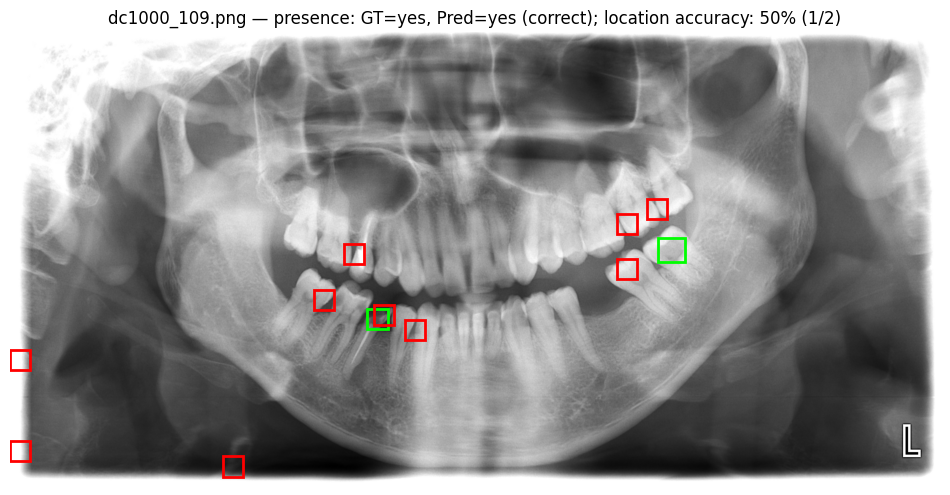

In [ ]:
# Unified visualization (no metric names shown), uses IOA>=0.25 by default
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# choose a validation image with labels
val_imgs = sorted(glob.glob(os.path.join(VAL_DIR, 'images', '*.*')))
vis_path = val_imgs[0]
vis_img = io.imread(vis_path, as_gray=True)
vis_fname = os.path.basename(vis_path)

# GT
lbl_path = os.path.join(VAL_DIR, 'labels', os.path.splitext(vis_fname)[0] + '.txt')
yolo_b = read_yolo(lbl_path)
H, W = vis_img.shape
gt_boxes = [yolo_to_xyxy(b, W, H) for b in yolo_b]
gt_boxes = [b for b in gt_boxes if b is not None]

# Detect
boxes = detect_image_lm(vis_img, ws=(64,64), step=48, thresh=None, nms_iou=0.3, max_detections=10)
boxes = boxes.tolist() if hasattr(boxes, 'tolist') else boxes

# Presence (yes/no cavity)
has_gt = len(gt_boxes) > 0
has_pred = len(boxes) > 0
presence_correct = (has_gt == has_pred)

# Location accuracy using IOA>=0.25 (not printed in title as 'ioa')
loc_thresh = 0.25
matches, fp_idx, fn_idx = match_dets_to_gts(boxes, gt_boxes, thresh=loc_thresh, metric='ioa')
num_overlap = len(matches)
num_gt = len(gt_boxes)

presence_str = f"presence: GT={'yes' if has_gt else 'no'}, Pred={'yes' if has_pred else 'no'} ({'correct' if presence_correct else 'incorrect'})"
if num_gt > 0:
    loc_acc_pct = 100.0 * num_overlap / num_gt
    location_str = f"location accuracy: {loc_acc_pct:.0f}% ({num_overlap}/{num_gt})"
else:
    location_str = "location accuracy: N/A (0 GT)"

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(vis_img, cmap='gray')
ax.set_title(f"{vis_fname} — {presence_str}; {location_str}")

# draw GT (green)
for (x1,y1,x2,y2) in gt_boxes:
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor='lime', fill=False, linewidth=2))

# draw detections (red)
for (x1,y1,x2,y2) in boxes:
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor='red', fill=False, linewidth=2))

ax.axis('off')
plt.show()


